In [38]:
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif, VarianceThreshold

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# I. Подготовка данных.

In [6]:
df = pd.read_excel('default of credit card clients.xls', skiprows=1)

In [7]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [8]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [9]:
df.set_index('ID', inplace=True)

In [10]:
df.select_dtypes(exclude='object').head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [11]:
X = df.drop('default payment next month', axis=1)
y = df['default payment next month']

# II. Filter methods

## 1. Mutual information

In [12]:
# feature extraction
#mutual_info = SelectKBest(score_func=mutual_info_classif, k=20)
#mutual_info.fit(X, y)

SelectKBest(k=20,
      score_func=<function mutual_info_classif at 0x000002C03AA32158>)

In [13]:
mutual_info.scores_

array([0.01913521, 0.00140194, 0.        , 0.        , 0.00416452,
       0.07419616, 0.04288752, 0.04135072, 0.03516015, 0.02996812,
       0.02690065, 0.00900068, 0.00537399, 0.00703147, 0.00502561,
       0.00682803, 0.00535035, 0.02316852, 0.01680081, 0.02135822,
       0.01655712, 0.01617399, 0.0134794 ])

In [14]:
X_new = mutual_info.transform(X)

In [32]:
mutual_info.get_params()

{'k': 20,
 'score_func': <function sklearn.feature_selection.mutual_info_.mutual_info_classif(X, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>}

In [62]:
mutual_information = mutual_info_classif(X, y)

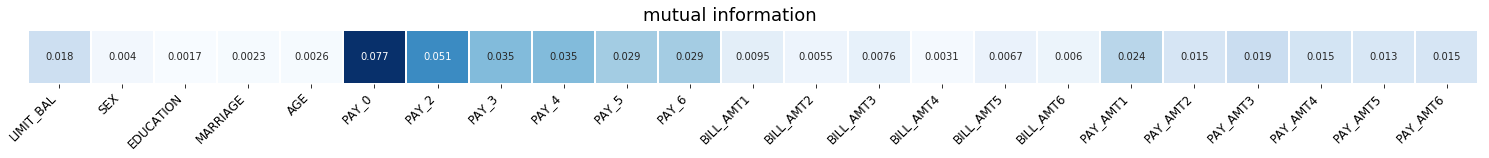

In [64]:
plt.subplots(1, figsize=(26, 1))
sns.heatmap(mutual_information.reshape(1, -1), cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(X.columns, rotation=45, ha='right', fontsize=12)
plt.suptitle("mutual information", fontsize=18, y=1.2)
plt.show()

In [70]:
mutual_information_threshold = 0.01
X_new = X[X.columns[mutual_information > mutual_information_threshold]]

In [71]:
X_new.shape

(30000, 13)

In [16]:
def gini(target, feature):
    return 2*roc_auc_score(target, feature) - 1

# III. Modeling

In [17]:
X_new.shape

(30000, 20)

In [18]:
import xgboost as xgb

In [19]:
xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'n_jobs': -1,
    'objective': 'binary:logistic', 
    'tree_method': 'gpu_exact'
}

In [20]:
model = xgb.XGBClassifier(**xgb_params)

In [21]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, tree_method='gpu_exact')

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_new, y, test_size=0.33, random_state=42, stratify=y)

In [24]:
%%time
model.fit(X_new, y, early_stopping_rounds=10, eval_metric=['logloss', 'auc'], eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)

[0]	validation_0-logloss:0.688686	validation_0-auc:0.734957	validation_1-logloss:0.688717	validation_1-auc:0.732052
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.684312	validation_0-auc:0.734957	validation_1-logloss:0.684375	validation_1-auc:0.732052
[2]	validation_0-logloss:0.680025	validation_0-auc:0.73505	validation_1-logloss:0.68012	validation_1-auc:0.732135
[3]	validation_0-logloss:0.675822	validation_0-auc:0.735079	validation_1-logloss:0.675947	validation_1-auc:0.732241
[4]	validation_0-logloss:0.671701	validation_0-auc:0.735079	validation_1-logloss:0.671856	validation_1-auc:0.732241
[5]	validation_0-logloss:0.667657	validation_0-auc:0.749493	validation_1-logloss:0.66785	validation_1-auc:0.744716
[6]	validation_0-logloss:0.663693	validation_0-auc:0.749493	validation_1-logloss:0.663917	validation_1-auc:0.744716
[7]	validation_0-logloss:0.659803	

[69]	validation_0-logloss:0.515214	validation_0-auc:0.767879	validation_1-logloss:0.517272	validation_1-auc:0.762262
[70]	validation_0-logloss:0.5139	validation_0-auc:0.768177	validation_1-logloss:0.515977	validation_1-auc:0.762562
[71]	validation_0-logloss:0.512604	validation_0-auc:0.768157	validation_1-logloss:0.514706	validation_1-auc:0.762525
[72]	validation_0-logloss:0.511327	validation_0-auc:0.768256	validation_1-logloss:0.513457	validation_1-auc:0.762576
[73]	validation_0-logloss:0.510066	validation_0-auc:0.768554	validation_1-logloss:0.512208	validation_1-auc:0.762951
[74]	validation_0-logloss:0.508831	validation_0-auc:0.76854	validation_1-logloss:0.511001	validation_1-auc:0.762874
[75]	validation_0-logloss:0.507613	validation_0-auc:0.768626	validation_1-logloss:0.509815	validation_1-auc:0.762848
[76]	validation_0-logloss:0.506407	validation_0-auc:0.768831	validation_1-logloss:0.508634	validation_1-auc:0.763033
[77]	validation_0-logloss:0.505233	validation_0-auc:0.768838	valida

[139]	validation_0-logloss:0.458922	validation_0-auc:0.773882	validation_1-logloss:0.462297	validation_1-auc:0.76833
[140]	validation_0-logloss:0.458476	validation_0-auc:0.773933	validation_1-logloss:0.461868	validation_1-auc:0.76839
[141]	validation_0-logloss:0.458042	validation_0-auc:0.774037	validation_1-logloss:0.461433	validation_1-auc:0.768488
[142]	validation_0-logloss:0.457608	validation_0-auc:0.774103	validation_1-logloss:0.461011	validation_1-auc:0.768422
[143]	validation_0-logloss:0.457184	validation_0-auc:0.774096	validation_1-logloss:0.460604	validation_1-auc:0.768411
[144]	validation_0-logloss:0.456757	validation_0-auc:0.7743	validation_1-logloss:0.460187	validation_1-auc:0.768698
[145]	validation_0-logloss:0.456347	validation_0-auc:0.774398	validation_1-logloss:0.459781	validation_1-auc:0.768856
[146]	validation_0-logloss:0.455945	validation_0-auc:0.774394	validation_1-logloss:0.459387	validation_1-auc:0.768845
[147]	validation_0-logloss:0.45555	validation_0-auc:0.774409

[209]	validation_0-logloss:0.439223	validation_0-auc:0.778419	validation_1-logloss:0.443407	validation_1-auc:0.772679
[210]	validation_0-logloss:0.439054	validation_0-auc:0.77846	validation_1-logloss:0.443247	validation_1-auc:0.772697
[211]	validation_0-logloss:0.438885	validation_0-auc:0.778519	validation_1-logloss:0.443085	validation_1-auc:0.772761
[212]	validation_0-logloss:0.438723	validation_0-auc:0.778534	validation_1-logloss:0.442936	validation_1-auc:0.772729
[213]	validation_0-logloss:0.438565	validation_0-auc:0.778525	validation_1-logloss:0.442783	validation_1-auc:0.772793
[214]	validation_0-logloss:0.438401	validation_0-auc:0.778584	validation_1-logloss:0.442627	validation_1-auc:0.772824
[215]	validation_0-logloss:0.438238	validation_0-auc:0.778636	validation_1-logloss:0.442474	validation_1-auc:0.772888
[216]	validation_0-logloss:0.438082	validation_0-auc:0.778648	validation_1-logloss:0.442328	validation_1-auc:0.772894
[217]	validation_0-logloss:0.437926	validation_0-auc:0.77

[279]	validation_0-logloss:0.431261	validation_0-auc:0.782182	validation_1-logloss:0.435969	validation_1-auc:0.775949
[280]	validation_0-logloss:0.43119	validation_0-auc:0.782229	validation_1-logloss:0.435906	validation_1-auc:0.776013
[281]	validation_0-logloss:0.431122	validation_0-auc:0.782254	validation_1-logloss:0.435843	validation_1-auc:0.775996
[282]	validation_0-logloss:0.43105	validation_0-auc:0.782264	validation_1-logloss:0.435778	validation_1-auc:0.776043
[283]	validation_0-logloss:0.43098	validation_0-auc:0.782297	validation_1-logloss:0.435709	validation_1-auc:0.77605
[284]	validation_0-logloss:0.430916	validation_0-auc:0.782403	validation_1-logloss:0.435628	validation_1-auc:0.776169
[285]	validation_0-logloss:0.430847	validation_0-auc:0.782484	validation_1-logloss:0.435546	validation_1-auc:0.776224
[286]	validation_0-logloss:0.43078	validation_0-auc:0.782534	validation_1-logloss:0.435488	validation_1-auc:0.77627
[287]	validation_0-logloss:0.43071	validation_0-auc:0.782578	v

[349]	validation_0-logloss:0.427417	validation_0-auc:0.785393	validation_1-logloss:0.431982	validation_1-auc:0.779848
[350]	validation_0-logloss:0.427374	validation_0-auc:0.785404	validation_1-logloss:0.431947	validation_1-auc:0.779852
[351]	validation_0-logloss:0.427337	validation_0-auc:0.785454	validation_1-logloss:0.431917	validation_1-auc:0.779881
[352]	validation_0-logloss:0.427297	validation_0-auc:0.785539	validation_1-logloss:0.431864	validation_1-auc:0.78001
[353]	validation_0-logloss:0.42725	validation_0-auc:0.785595	validation_1-logloss:0.431808	validation_1-auc:0.780097
[354]	validation_0-logloss:0.427211	validation_0-auc:0.785622	validation_1-logloss:0.431754	validation_1-auc:0.780153
[355]	validation_0-logloss:0.427175	validation_0-auc:0.785646	validation_1-logloss:0.431719	validation_1-auc:0.780161
[356]	validation_0-logloss:0.427129	validation_0-auc:0.785719	validation_1-logloss:0.431665	validation_1-auc:0.780261
[357]	validation_0-logloss:0.427088	validation_0-auc:0.785

[419]	validation_0-logloss:0.425056	validation_0-auc:0.787611	validation_1-logloss:0.429332	validation_1-auc:0.783005
[420]	validation_0-logloss:0.425034	validation_0-auc:0.787639	validation_1-logloss:0.429305	validation_1-auc:0.783041
[421]	validation_0-logloss:0.425006	validation_0-auc:0.787654	validation_1-logloss:0.429268	validation_1-auc:0.7831
[422]	validation_0-logloss:0.424974	validation_0-auc:0.787672	validation_1-logloss:0.429229	validation_1-auc:0.783119
[423]	validation_0-logloss:0.424947	validation_0-auc:0.787721	validation_1-logloss:0.429196	validation_1-auc:0.783156
[424]	validation_0-logloss:0.424927	validation_0-auc:0.787747	validation_1-logloss:0.429169	validation_1-auc:0.7832
[425]	validation_0-logloss:0.424897	validation_0-auc:0.787772	validation_1-logloss:0.42913	validation_1-auc:0.783248
[426]	validation_0-logloss:0.424869	validation_0-auc:0.787819	validation_1-logloss:0.429088	validation_1-auc:0.783344
[427]	validation_0-logloss:0.424842	validation_0-auc:0.787833

[489]	validation_0-logloss:0.423334	validation_0-auc:0.789592	validation_1-logloss:0.427331	validation_1-auc:0.78592
[490]	validation_0-logloss:0.423315	validation_0-auc:0.789621	validation_1-logloss:0.427299	validation_1-auc:0.785966
[491]	validation_0-logloss:0.423291	validation_0-auc:0.789655	validation_1-logloss:0.427264	validation_1-auc:0.786037
[492]	validation_0-logloss:0.423267	validation_0-auc:0.789684	validation_1-logloss:0.427242	validation_1-auc:0.786077
[493]	validation_0-logloss:0.423242	validation_0-auc:0.789721	validation_1-logloss:0.427213	validation_1-auc:0.786118
[494]	validation_0-logloss:0.423224	validation_0-auc:0.789746	validation_1-logloss:0.427183	validation_1-auc:0.786171
[495]	validation_0-logloss:0.423202	validation_0-auc:0.789783	validation_1-logloss:0.427147	validation_1-auc:0.78624
[496]	validation_0-logloss:0.423174	validation_0-auc:0.789798	validation_1-logloss:0.427127	validation_1-auc:0.786262
[497]	validation_0-logloss:0.423156	validation_0-auc:0.789

[559]	validation_0-logloss:0.421875	validation_0-auc:0.791416	validation_1-logloss:0.425554	validation_1-auc:0.788569
[560]	validation_0-logloss:0.421861	validation_0-auc:0.791434	validation_1-logloss:0.425533	validation_1-auc:0.788604
[561]	validation_0-logloss:0.421839	validation_0-auc:0.791455	validation_1-logloss:0.425511	validation_1-auc:0.788638
[562]	validation_0-logloss:0.421821	validation_0-auc:0.791486	validation_1-logloss:0.425485	validation_1-auc:0.788686
[563]	validation_0-logloss:0.421793	validation_0-auc:0.791523	validation_1-logloss:0.425463	validation_1-auc:0.788715
[564]	validation_0-logloss:0.42178	validation_0-auc:0.79154	validation_1-logloss:0.425436	validation_1-auc:0.788762
[565]	validation_0-logloss:0.421764	validation_0-auc:0.791568	validation_1-logloss:0.42541	validation_1-auc:0.788816
[566]	validation_0-logloss:0.421744	validation_0-auc:0.791597	validation_1-logloss:0.42539	validation_1-auc:0.788841
[567]	validation_0-logloss:0.421729	validation_0-auc:0.79160

[629]	validation_0-logloss:0.4206	validation_0-auc:0.793249	validation_1-logloss:0.424091	validation_1-auc:0.790784
[630]	validation_0-logloss:0.420587	validation_0-auc:0.793267	validation_1-logloss:0.424075	validation_1-auc:0.790816
[631]	validation_0-logloss:0.420577	validation_0-auc:0.793284	validation_1-logloss:0.424061	validation_1-auc:0.790838
[632]	validation_0-logloss:0.42056	validation_0-auc:0.7933	validation_1-logloss:0.424052	validation_1-auc:0.790845
[633]	validation_0-logloss:0.420543	validation_0-auc:0.793328	validation_1-logloss:0.424035	validation_1-auc:0.790861
[634]	validation_0-logloss:0.420525	validation_0-auc:0.793358	validation_1-logloss:0.424012	validation_1-auc:0.790893
[635]	validation_0-logloss:0.420508	validation_0-auc:0.793388	validation_1-logloss:0.423988	validation_1-auc:0.790928
[636]	validation_0-logloss:0.420486	validation_0-auc:0.793411	validation_1-logloss:0.423974	validation_1-auc:0.790945
[637]	validation_0-logloss:0.420468	validation_0-auc:0.79344	

[699]	validation_0-logloss:0.41946	validation_0-auc:0.795008	validation_1-logloss:0.422859	validation_1-auc:0.792676
[700]	validation_0-logloss:0.419444	validation_0-auc:0.795028	validation_1-logloss:0.422842	validation_1-auc:0.792707
[701]	validation_0-logloss:0.419435	validation_0-auc:0.795043	validation_1-logloss:0.42283	validation_1-auc:0.792722
[702]	validation_0-logloss:0.419417	validation_0-auc:0.795069	validation_1-logloss:0.422816	validation_1-auc:0.792736
[703]	validation_0-logloss:0.419402	validation_0-auc:0.795089	validation_1-logloss:0.422803	validation_1-auc:0.792749
[704]	validation_0-logloss:0.419386	validation_0-auc:0.795113	validation_1-logloss:0.422782	validation_1-auc:0.792776
[705]	validation_0-logloss:0.419372	validation_0-auc:0.795133	validation_1-logloss:0.422769	validation_1-auc:0.792795
[706]	validation_0-logloss:0.419346	validation_0-auc:0.795195	validation_1-logloss:0.422748	validation_1-auc:0.792844
[707]	validation_0-logloss:0.419326	validation_0-auc:0.795

[769]	validation_0-logloss:0.418359	validation_0-auc:0.796797	validation_1-logloss:0.421668	validation_1-auc:0.794705
[770]	validation_0-logloss:0.418338	validation_0-auc:0.796838	validation_1-logloss:0.421644	validation_1-auc:0.794763
[771]	validation_0-logloss:0.418323	validation_0-auc:0.796855	validation_1-logloss:0.421628	validation_1-auc:0.794782
[772]	validation_0-logloss:0.418304	validation_0-auc:0.796893	validation_1-logloss:0.421607	validation_1-auc:0.794816
[773]	validation_0-logloss:0.418295	validation_0-auc:0.796906	validation_1-logloss:0.421598	validation_1-auc:0.794827
[774]	validation_0-logloss:0.418282	validation_0-auc:0.796924	validation_1-logloss:0.421583	validation_1-auc:0.794848
[775]	validation_0-logloss:0.418269	validation_0-auc:0.796942	validation_1-logloss:0.421566	validation_1-auc:0.794871
[776]	validation_0-logloss:0.41826	validation_0-auc:0.796965	validation_1-logloss:0.421559	validation_1-auc:0.794885
[777]	validation_0-logloss:0.418245	validation_0-auc:0.79

[839]	validation_0-logloss:0.417382	validation_0-auc:0.79825	validation_1-logloss:0.420577	validation_1-auc:0.796385
[840]	validation_0-logloss:0.417368	validation_0-auc:0.798281	validation_1-logloss:0.420566	validation_1-auc:0.796407
[841]	validation_0-logloss:0.417361	validation_0-auc:0.798297	validation_1-logloss:0.420558	validation_1-auc:0.796419
[842]	validation_0-logloss:0.41735	validation_0-auc:0.798311	validation_1-logloss:0.420543	validation_1-auc:0.796436
[843]	validation_0-logloss:0.417343	validation_0-auc:0.798322	validation_1-logloss:0.420532	validation_1-auc:0.796449
[844]	validation_0-logloss:0.417331	validation_0-auc:0.798332	validation_1-logloss:0.42052	validation_1-auc:0.796461
[845]	validation_0-logloss:0.417319	validation_0-auc:0.79835	validation_1-logloss:0.420498	validation_1-auc:0.7965
[846]	validation_0-logloss:0.417305	validation_0-auc:0.798364	validation_1-logloss:0.420485	validation_1-auc:0.796516
[847]	validation_0-logloss:0.417294	validation_0-auc:0.79838	v

[909]	validation_0-logloss:0.416556	validation_0-auc:0.799499	validation_1-logloss:0.419705	validation_1-auc:0.797706
[910]	validation_0-logloss:0.416538	validation_0-auc:0.799541	validation_1-logloss:0.41969	validation_1-auc:0.797733
[911]	validation_0-logloss:0.416522	validation_0-auc:0.799571	validation_1-logloss:0.419679	validation_1-auc:0.797757
[912]	validation_0-logloss:0.416512	validation_0-auc:0.799577	validation_1-logloss:0.419665	validation_1-auc:0.797765
[913]	validation_0-logloss:0.416495	validation_0-auc:0.799596	validation_1-logloss:0.419653	validation_1-auc:0.797783
[914]	validation_0-logloss:0.416478	validation_0-auc:0.799626	validation_1-logloss:0.419642	validation_1-auc:0.797806
[915]	validation_0-logloss:0.416465	validation_0-auc:0.799653	validation_1-logloss:0.419626	validation_1-auc:0.797835
[916]	validation_0-logloss:0.416453	validation_0-auc:0.799658	validation_1-logloss:0.419615	validation_1-auc:0.797842
[917]	validation_0-logloss:0.41644	validation_0-auc:0.799

[979]	validation_0-logloss:0.415734	validation_0-auc:0.800814	validation_1-logloss:0.418928	validation_1-auc:0.798944
[980]	validation_0-logloss:0.415721	validation_0-auc:0.80084	validation_1-logloss:0.418909	validation_1-auc:0.798968
[981]	validation_0-logloss:0.415716	validation_0-auc:0.800851	validation_1-logloss:0.418904	validation_1-auc:0.798978
[982]	validation_0-logloss:0.415709	validation_0-auc:0.800864	validation_1-logloss:0.41889	validation_1-auc:0.798997
[983]	validation_0-logloss:0.415701	validation_0-auc:0.800874	validation_1-logloss:0.418882	validation_1-auc:0.799006
[984]	validation_0-logloss:0.415695	validation_0-auc:0.800886	validation_1-logloss:0.418874	validation_1-auc:0.799021
[985]	validation_0-logloss:0.415684	validation_0-auc:0.800903	validation_1-logloss:0.418862	validation_1-auc:0.799042
[986]	validation_0-logloss:0.415679	validation_0-auc:0.800911	validation_1-logloss:0.418859	validation_1-auc:0.799046
[987]	validation_0-logloss:0.415666	validation_0-auc:0.800

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, tree_method='gpu_exact')

In [25]:
y_pred = model.predict_proba(X_val)[:, 1]

In [29]:
y_pred.shape

(9900,)

In [27]:
gini(y_val, y_pred)

0.5984904855817921

In [30]:
roc_auc_score(y_val, y_pred)

0.799245242790896

In [ ]:
def rmsle(y_pred, y_true):
    y_pred = [x if x >= 1.0 else 1.0 for x in y_pred]
    y_true = [x if x >= 1.0 else 1.0 for x in y_true]
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [ ]:
fit_params = {
    "early_stopping_rounds":10, 
    "eval_metric" : rmsle_eval, 
    "eval_set" : [[X_val, y_val]]
}

In [ ]:
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [ ]:
grid_search = GridSearchCV(model, param_grid=param_grid, )

In [ ]:
grid = RandomizedSearchCV(xgb_model, scoring=rmsle_scorer, param_distributions=params,
                                   n_iter=10, cv=3, n_jobs=1, verbose=1, fit_params=fit_params)
grid.fit(X_train, y_train)